In [1]:
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization
from matplotlib import pyplot as plt
from functools import partial
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, Lambda
from tensorflow.keras import regularizers
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import cv2
import os
import keras

In [2]:
df_X = pd.read_csv('dataset/train_features.csv')
df_y = pd.read_csv('dataset/train_target.csv')

In [3]:
df_X

id      Time         S1        S2         S3         S4
0           0  0.000000       0.00       0.0       0.00       0.00
1           0  0.000004       0.00       0.0       0.00       0.00
2           0  0.000008       0.00       0.0       0.00       0.00
3           0  0.000012       0.00       0.0       0.00       0.00
4           0  0.000016       0.00       0.0       0.00       0.00
...       ...       ...        ...       ...        ...        ...
1049995  2799  0.001480  -89256.32 -164614.6   48186.29 -147910.20
1049996  2799  0.001484  -29233.44 -179404.2  109534.40 -111591.10
1049997  2799  0.001488   37147.25 -190011.7  178781.10  -86836.78
1049998  2799  0.001492   98278.50 -190771.4  245726.70  -75660.00
1049999  2799  0.001496  151683.00 -177267.3  307932.80  -72835.82

[1050000 rows x 6 columns]

In [4]:
df_y

id      X      Y      M    V
0        0    0.0 -400.0   50.0  0.4
1        1  400.0    0.0  100.0  1.0
2        2 -300.0 -200.0   25.0  0.4
3        3  200.0 -100.0  150.0  0.4
4        4 -300.0 -100.0  150.0  0.4
...    ...    ...    ...    ...  ...
2795  2795  200.0  200.0   50.0  1.0
2796  2796 -400.0 -400.0  150.0  0.2
2797  2797 -100.0    0.0   50.0  0.2
2798  2798  100.0  100.0  125.0  0.6
2799  2799  100.0 -200.0  100.0  0.6

[2800 rows x 5 columns]

In [5]:
for col in df_X.columns:
    print(f'{col}: {df_X[col].isnull().values.any()}')
for col in df_y.columns:
    print(f'{col}: {df_y[col].isnull().values.any()}')

id: False
Time: False
S1: False
S2: False
S3: False
S4: False
id: False
X: False
Y: False
M: False
V: False


In [6]:
def data_processing(data_frame,feature_list,conc_list=list()):
    for feature in feature_list:
        conc_list.append(np.asarray(data_frame[feature]).reshape(-1,375,1))
    conc_array = np.concatenate(conc_list,axis=2)
    array = conc_array.transpose(0,2,1)
    return array

(2800, 4, 375)


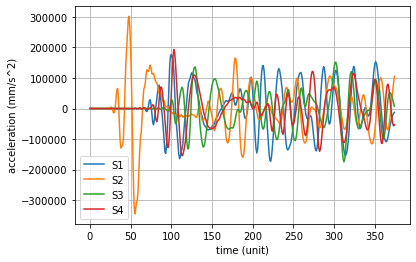

In [7]:
data = data_processing(df_X,['S1','S2','S3','S4'])

plt.figure(figsize=(6,4))
plt.plot(data[777].T)
plt.legend(['S1','S2','S3','S4'])
plt.grid(True)
plt.xlabel('time (unit)')
plt.ylabel('acceleration (mm/s^2)')

x = data
print(x.shape)

In [8]:
data.shape

(2800, 4, 375)

In [9]:
def generate_agg_feats(data_set : pd.DataFrame) -> pd.DataFrame:
    
    max_feats = data_set.groupby(['id']).max().add_suffix('_max').iloc[:,1:]
    min_feats = data_set.groupby(['id']).min().add_suffix('_min').iloc[:,1:]
    mean_feats = data_set.groupby(['id']).mean().add_suffix('_mean').iloc[:,1:]
    std_feats = data_set.groupby(['id']).std().add_suffix('_std').iloc[:,1:]
    median_feats = data_set.groupby(['id']).median().add_suffix('_median').iloc[:,1:]
    skew_feats = data_set.groupby(['id']).skew().add_suffix('_skew').iloc[:,1:]
    
    agg_data = pd.concat([max_feats,min_feats,
                          mean_feats,std_feats,median_feats,skew_feats],
                        axis=1)
    
    return agg_data

In [10]:
df_X = generate_agg_feats(df_X)

In [11]:
df_X

S1_max      S2_max     S3_max     S4_max    S1_min      S2_min  \
id                                                                        
0      235080.9   235080.90   231773.4   286557.2 -315471.5  -315471.50   
1     1069688.0  1244737.00   951349.6  1095499.0 -826482.9 -2390317.00   
2      383092.2   150770.40   148724.0   168649.2 -364591.8  -161006.00   
3      379650.3   378475.30   394448.7   487880.4 -329680.7  -726961.00   
4      754833.0   321731.20   373526.8   397334.0 -592148.9  -378091.60   
...         ...         ...        ...        ...       ...         ...   
2795   698079.1  1027622.00  1031316.0  1037711.0 -793812.4  -720545.40   
2796   290787.9   144759.00   119504.7   157180.4 -493104.6  -179902.70   
2797   109273.7    98441.96   109713.6   162800.1 -127440.0   -90686.41   
2798   576629.1   550360.40   803728.8   878377.7 -587942.2  -742554.80   
2799   648335.8   965234.70   499031.7   645815.6 -571597.8  -627908.20   

         S3_min     S4_min       S1_mean       S2_mean  ...         S3_std  \
id                                                      ...                  
0     -168789.1  -293865.7   -308.304553   -308.304553  ...   73381.881823   
1    -1137225.0 -1306526.0  12780.176893    981.778780  ...  393470.633500   
2     -150458.2  -201313.7   -674.289628  -1575.681938  ...   53274.867908   
3     -333712.8  -463918.9   2164.216981 -11274.728589  ...  144260.409981   
4     -423593.5  -472361.4   -980.480585  -6966.912566  ...  150043.470527   
...         ...        ...           ...           ...  ...            ...   
2795 -1155664.0 -1703724.0   5600.614397   5885.824925  ...  312439.374562   
2796  -100318.6  -180438.7  -1215.328099   2702.879683  ...   43118.928262   
2797  -101889.3  -123130.7    436.239993    276.327514  ...   38062.358026   
2798  -811196.2 -1196096.0  -2394.515047   6230.349355  ...  264922.977643   
2799  -492273.2  -621268.9   1059.619352     28.166706  ...  181206.965517   

             S4_std     S1_median     S2_median     S3_median     S4_median  \
id                                                                            
0      93657.794500    -17.249630    -17.249630  0.000000e+00      0.008652   
1     468914.485995      0.000000  -1090.979000  1.053139e-06      0.000000   
2      64025.270683  -8063.518000      0.000000  0.000000e+00      0.000000   
3     143137.423122      0.000118 -10742.910000  5.255491e-07     21.546210   
4     131857.519354 -19297.320000      0.000000  1.173251e-05   1384.087000   
...             ...           ...           ...           ...           ...   
2795  359013.359936      0.000797      0.000000  0.000000e+00 -31130.460000   
2796   59443.406732   1667.086000      0.001836  0.000000e+00      0.000000   
2797   40343.480882      0.211343      0.000105  0.000000e+00     -0.000364   
2798  295498.567656      0.047959      0.000000  0.000000e+00 -26957.400000   
2799  231418.332855      0.000000      0.000000 -5.118270e+01      0.000000   

       S1_skew   S2_skew   S3_skew   S4_skew  
id                                            
0    -0.000219 -0.000219  0.299376 -0.212332  
1     0.521826 -0.701078 -0.088361  0.018837  
2     0.516960 -0.087335  0.160090 -0.100796  
3    -0.055517 -0.475508 -0.089726  0.113817  
4     0.826098 -0.107505 -0.157477 -0.216489  
...        ...       ...       ...       ...  
2795 -0.042545  0.247155  0.001388 -0.583126  
2796 -1.639586 -0.353089  0.311429 -0.357093  
2797 -0.017294  0.075720  0.135764  0.301025  
2798 -0.134274  0.031148  0.180638 -0.143045  
2799 -0.118763  0.320309  0.193161  0.097023  

[2800 rows x 24 columns]

In [12]:
x_list = df_X.to_numpy().tolist()

In [14]:
y = df_y.drop(['id','M','V'],axis=1)
y_numpy = y.to_numpy()
y_list = y_numpy.tolist()

In [15]:
train_test_index = int(len(x_list)*0.8)
zip_list = list(zip(x_list,y_list))
random.shuffle(zip_list)
x_array,y_array = zip(*zip_list)
x_train,y_train = np.array(x_array[0:train_test_index]),np.array(y_array[0:train_test_index])
x_test,y_test = np.array(x_array[train_test_index:]),np.array(y_array[train_test_index:])

In [16]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
x_train_scaled = standard_scaler.fit_transform(x_train)
x_test_scaled = standard_scaler.fit_transform(x_test)
x_train_scaled

array([[-0.789391  , -1.08198345, -1.10240892, ...,  0.02245793,
        -0.16338   , -0.39518849],
       [-0.59372309, -0.54990707, -0.34147252, ..., -0.37606189,
        -0.13750813,  0.81164971],
       [-1.07467603, -1.07876248, -0.73224122, ..., -0.47347047,
         3.69774828, -3.50184189],
       ...,
       [-0.98629911, -0.98112259, -0.90788674, ..., -0.21970858,
        -0.91311747,  1.00016562],
       [-0.7588863 , -0.97885964, -1.07272862, ..., -0.53606955,
         1.29642568, -0.21491055],
       [-0.95897436, -0.98737742, -0.79984171, ...,  0.07278119,
         1.61098074, -2.79730471]])

In [17]:
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = minmax_scaler.fit_transform(y_train)
y_test_scaled = minmax_scaler.fit_transform(y_test)
#y_train_scaled = np.ravel(y_train_scaled)

In [18]:
y_train_scaled.shape

(2240, 2)

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline

In [20]:
pipelines = []
pipelines.append(('LR', Pipeline([('LR',LinearRegression())])))
pipelines.append(('LASSO', Pipeline([('LASSO', Lasso())])))
pipelines.append(('ENet', Pipeline([('EN', ElasticNet())])))
pipelines.append(('KNN', Pipeline([('KNN', KNeighborsRegressor())])))
pipelines.append(('CART', Pipeline([('CART', DecisionTreeRegressor())])))
pipelines.append(('GBM', Pipeline([('GBM', GradientBoostingRegressor())])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, x_train_scaled, y_train_scaled, cv=kfold, scoring='neg_mean_absolute_error')
    results.append(-cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, np.array(results).mean(), np.array(results).std())
    print(msg)
    results = []

LR: 0.164100 (0.006829)
LASSO: 0.278302 (0.004139)
ENet: 0.278302 (0.004139)
KNN: 0.088025 (0.005725)
CART: 0.062807 (0.004451)
GBM: nan (nan)


D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\anaconda\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\anaconda\lib\site-packages\sklearn\ensemble\_gb.py", line 417, in fit
    y = column_or_1d(y, warn=True)
  File "D:\anaconda\lib\site-packages\sklearn\utils\validation.py", line 72, in inner_f
    return f(**kwargs)
  File "D:\anaconda\lib\site-packages\sklearn\utils\validation.py", line 845, in column_or_1d
    raise ValueError(
ValueError: y should be a 1d array, got an array of shape (2016, 2) instead.

  warnings.warn("Estimator fit failed. The sc

In [97]:
from sklearn.model_selection import GridSearchCV

#scaler = StandardScaler().fit(X_train)
#rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=np.array([50,75,100,150,200,300,400]), learning_rate = np.array([0.01,0.05,0.1,0.2,0.3,0.5]),max_features = np.array([3,4,5,6,7]))
model = GradientBoostingRegressor()
kfold = KFold(n_splits=5)
grid = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=kfold)
grid_result = grid.fit(x_train_scaled, y_train_scaled)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

-0.270753 (0.005229) with: {'learning_rate': 0.01, 'max_features': 3, 'n_estimators': 50}
-0.263314 (0.005307) with: {'learning_rate': 0.01, 'max_features': 3, 'n_estimators': 75}
-0.257859 (0.005412) with: {'learning_rate': 0.01, 'max_features': 3, 'n_estimators': 100}
-0.249030 (0.005018) with: {'learning_rate': 0.01, 'max_features': 3, 'n_estimators': 150}
-0.242232 (0.004966) with: {'learning_rate': 0.01, 'max_features': 3, 'n_estimators': 200}
-0.230167 (0.005142) with: {'learning_rate': 0.01, 'max_features': 3, 'n_estimators': 300}
-0.220647 (0.004678) with: {'learning_rate': 0.01, 'max_features': 3, 'n_estimators': 400}
-0.269908 (0.005186) with: {'learning_rate': 0.01, 'max_features': 4, 'n_estimators': 50}
-0.262551 (0.005372) with: {'learning_rate': 0.01, 'max_features': 4, 'n_estimators': 75}
-0.256481 (0.005277) with: {'learning_rate': 0.01, 'max_features': 4, 'n_estimators': 100}
-0.248010 (0.005037) with: {'learning_rate': 0.01, 'max_features': 4, 'n_estimators': 150}
-0.

In [100]:
from sklearn.metrics import mean_absolute_error as mae
gb_reg = GradientBoostingRegressor(learning_rate = 0.3, max_features = 7, n_estimators = 400)
gb_reg.fit(x_train_scaled, y_train_scaled)
y_pred = gb_reg.predict(x_test_scaled)
MAE = mae(y_test_scaled, y_pred)

In [101]:
MAE

0.1314831836812345

In [96]:
from sklearn.model_selection import GridSearchCV

#scaler = StandardScaler().fit(X_train)
#rescaledX = scaler.transform(X_train)
param_grid={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }
#param_grid = dict(n_estimators=np.array([50,75,100,150,200,300,400]),max_features = np.array([3,4,5,6,7]))
model = DecisionTreeRegressor()
kfold = KFold(n_splits=5)
grid = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=kfold)
grid_result = grid.fit(x_train_scaled, y_train_scaled)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

-0.274569 (0.006895) with: {'max_depth': 1, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}
-0.274150 (0.006171) with: {'max_depth': 1, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.1, 'splitter': 'random'}
-0.274569 (0.006895) with: {'max_depth': 1, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.15, 'splitter': 'best'}
-0.275469 (0.008075) with: {'max_depth': 1, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.15, 'splitter': 'random'}
-0.274569 (0.006895) with: {'max_depth': 1, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.2, 'splitter': 'best'}
-0.272453 (0.007816) with: {'max_depth': 1, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.2, 'split

-0.279692 (0.007838) with: {'max_depth': 1, 'max_features': 'log2', 'max_leaf_nodes': 20, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.4, 'splitter': 'best'}
-0.290813 (0.006158) with: {'max_depth': 1, 'max_features': 'log2', 'max_leaf_nodes': 20, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.4, 'splitter': 'random'}
-0.281996 (0.007676) with: {'max_depth': 1, 'max_features': 'log2', 'max_leaf_nodes': 20, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.45, 'splitter': 'best'}
-0.286939 (0.007649) with: {'max_depth': 1, 'max_features': 'log2', 'max_leaf_nodes': 20, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.45, 'splitter': 'random'}
-0.285778 (0.003977) with: {'max_depth': 1, 'max_features': 'log2', 'max_leaf_nodes': 20, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.5, 'splitter': 'best'}
-0.290813 (0.006158) with: {'max_depth': 1, 'max_features': 'log2', 'max_leaf_nodes': 20, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.5, 'splitter': 'rando

-0.290813 (0.006158) with: {'max_depth': 1, 'max_features': 'log2', 'max_leaf_nodes': 90, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.45, 'splitter': 'random'}
-0.284803 (0.004180) with: {'max_depth': 1, 'max_features': 'log2', 'max_leaf_nodes': 90, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.5, 'splitter': 'best'}
-0.290813 (0.006158) with: {'max_depth': 1, 'max_features': 'log2', 'max_leaf_nodes': 90, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.5, 'splitter': 'random'}
-0.277354 (0.005243) with: {'max_depth': 1, 'max_features': 'log2', 'max_leaf_nodes': 90, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}
-0.281609 (0.007497) with: {'max_depth': 1, 'max_features': 'log2', 'max_leaf_nodes': 90, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.1, 'splitter': 'random'}
-0.275191 (0.007446) with: {'max_depth': 1, 'max_features': 'log2', 'max_leaf_nodes': 90, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.15, 'splitter': 'bes

-0.290813 (0.006158) with: {'max_depth': 1, 'max_features': 'sqrt', 'max_leaf_nodes': 70, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.5, 'splitter': 'random'}
-0.277140 (0.010210) with: {'max_depth': 1, 'max_features': 'sqrt', 'max_leaf_nodes': 80, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}
-0.279947 (0.009014) with: {'max_depth': 1, 'max_features': 'sqrt', 'max_leaf_nodes': 80, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.1, 'splitter': 'random'}
-0.278585 (0.007264) with: {'max_depth': 1, 'max_features': 'sqrt', 'max_leaf_nodes': 80, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.15, 'splitter': 'best'}
-0.289862 (0.005996) with: {'max_depth': 1, 'max_features': 'sqrt', 'max_leaf_nodes': 80, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.15, 'splitter': 'random'}
-0.277829 (0.006600) with: {'max_depth': 1, 'max_features': 'sqrt', 'max_leaf_nodes': 80, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.2, 'splitter': 'be

-0.288973 (0.004665) with: {'max_depth': 1, 'max_features': None, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.45, 'splitter': 'random'}
-0.281402 (0.002205) with: {'max_depth': 1, 'max_features': None, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.5, 'splitter': 'best'}
-0.290813 (0.006158) with: {'max_depth': 1, 'max_features': None, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.5, 'splitter': 'random'}
-0.274569 (0.006895) with: {'max_depth': 1, 'max_features': None, 'max_leaf_nodes': 60, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}
-0.275968 (0.009690) with: {'max_depth': 1, 'max_features': None, 'max_leaf_nodes': 60, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.1, 'splitter': 'random'}
-0.274569 (0.006895) with: {'max_depth': 1, 'max_features': None, 'max_leaf_nodes': 60, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.15, 'splitter': 'best'}
-0.27771

-0.273384 (0.006666) with: {'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': 90, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.15, 'splitter': 'random'}
-0.267221 (0.005887) with: {'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': 90, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.2, 'splitter': 'best'}
-0.273703 (0.005517) with: {'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': 90, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.2, 'splitter': 'random'}
-0.267761 (0.005520) with: {'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': 90, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.25, 'splitter': 'best'}
-0.277487 (0.004802) with: {'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': 90, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.25, 'splitter': 'random'}
-0.270234 (0.005983) with: {'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': 90, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.3, 'splitter': 'be

-0.291027 (0.005854) with: {'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 50, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.3, 'splitter': 'random'}
-0.280904 (0.005066) with: {'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 50, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.35, 'splitter': 'best'}
-0.289267 (0.004763) with: {'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 50, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.35, 'splitter': 'random'}
-0.279380 (0.008200) with: {'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 50, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.4, 'splitter': 'best'}
-0.290813 (0.006158) with: {'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 50, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.4, 'splitter': 'random'}
-0.280731 (0.006515) with: {'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 50, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.45, 'splitter': 'be

-0.288423 (0.009041) with: {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 70, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.3, 'splitter': 'random'}
-0.275356 (0.007759) with: {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 70, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.35, 'splitter': 'best'}
-0.290614 (0.006452) with: {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 70, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.35, 'splitter': 'random'}
-0.276001 (0.005288) with: {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 70, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.4, 'splitter': 'best'}
-0.289178 (0.005654) with: {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 70, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.4, 'splitter': 'random'}
-0.284711 (0.010495) with: {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 70, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.45, 'splitter

-0.270189 (0.006034) with: {'max_depth': 3, 'max_features': None, 'max_leaf_nodes': 60, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.1, 'splitter': 'random'}
-0.264112 (0.006886) with: {'max_depth': 3, 'max_features': None, 'max_leaf_nodes': 60, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.15, 'splitter': 'best'}
-0.271565 (0.007719) with: {'max_depth': 3, 'max_features': None, 'max_leaf_nodes': 60, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.15, 'splitter': 'random'}
-0.267221 (0.005887) with: {'max_depth': 3, 'max_features': None, 'max_leaf_nodes': 60, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.2, 'splitter': 'best'}
-0.278781 (0.005131) with: {'max_depth': 3, 'max_features': None, 'max_leaf_nodes': 60, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.2, 'splitter': 'random'}
-0.267761 (0.005520) with: {'max_depth': 3, 'max_features': None, 'max_leaf_nodes': 60, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.25, 'splitter': 'best'}
-0.2772

-0.267077 (0.005811) with: {'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': 80, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.1, 'splitter': 'random'}
-0.262305 (0.007794) with: {'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': 80, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.15, 'splitter': 'best'}
-0.272343 (0.008348) with: {'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': 80, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.15, 'splitter': 'random'}
-0.267221 (0.005887) with: {'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': 80, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.2, 'splitter': 'best'}
-0.274117 (0.004749) with: {'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': 80, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.2, 'splitter': 'random'}
-0.267761 (0.005520) with: {'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': 80, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.25, 'splitter': 'be

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



-0.262305 (0.007794) with: {'max_depth': 9, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.15, 'splitter': 'best'}
-0.268073 (0.009937) with: {'max_depth': 9, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.15, 'splitter': 'random'}
-0.267221 (0.005887) with: {'max_depth': 9, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.2, 'splitter': 'best'}
-0.274112 (0.004600) with: {'max_depth': 9, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.2, 'splitter': 'random'}
-0.267761 (0.005520) with: {'max_depth': 9, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.25, 'splitter': 'best'}
-0.279510 (0.007308) with: {'max_depth': 9, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.25, 'splitter'

-0.267761 (0.005520) with: {'max_depth': 11, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.25, 'splitter': 'best'}
-0.279808 (0.009401) with: {'max_depth': 11, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.25, 'splitter': 'random'}
-0.270234 (0.005983) with: {'max_depth': 11, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.3, 'splitter': 'best'}
-0.282096 (0.008013) with: {'max_depth': 11, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.3, 'splitter': 'random'}
-0.274497 (0.006371) with: {'max_depth': 11, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.35, 'splitter': 'best'}
-0.282751 (0.011462) with: {'max_depth': 11, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.35

-0.268277 (0.003236) with: {'max_depth': 11, 'max_features': 'auto', 'max_leaf_nodes': 70, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.1, 'splitter': 'random'}
-0.262305 (0.007794) with: {'max_depth': 11, 'max_features': 'auto', 'max_leaf_nodes': 70, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.15, 'splitter': 'best'}
-0.273736 (0.006922) with: {'max_depth': 11, 'max_features': 'auto', 'max_leaf_nodes': 70, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.15, 'splitter': 'random'}
-0.267221 (0.005887) with: {'max_depth': 11, 'max_features': 'auto', 'max_leaf_nodes': 70, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.2, 'splitter': 'best'}
-0.278120 (0.007359) with: {'max_depth': 11, 'max_features': 'auto', 'max_leaf_nodes': 70, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.2, 'splitter': 'random'}
-0.267761 (0.005520) with: {'max_depth': 11, 'max_features': 'auto', 'max_leaf_nodes': 70, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.25, 'splitter

-0.274719 (0.010097) with: {'max_depth': 11, 'max_features': 'log2', 'max_leaf_nodes': 90, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.3, 'splitter': 'best'}
-0.290514 (0.006175) with: {'max_depth': 11, 'max_features': 'log2', 'max_leaf_nodes': 90, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.3, 'splitter': 'random'}
-0.279380 (0.009562) with: {'max_depth': 11, 'max_features': 'log2', 'max_leaf_nodes': 90, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.35, 'splitter': 'best'}
-0.288608 (0.005910) with: {'max_depth': 11, 'max_features': 'log2', 'max_leaf_nodes': 90, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.35, 'splitter': 'random'}
-0.278460 (0.007783) with: {'max_depth': 11, 'max_features': 'log2', 'max_leaf_nodes': 90, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.4, 'splitter': 'best'}
-0.287250 (0.007723) with: {'max_depth': 11, 'max_features': 'log2', 'max_leaf_nodes': 90, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.4, 'splitter': 

-0.280246 (0.010204) with: {'max_depth': 11, 'max_features': 'sqrt', 'max_leaf_nodes': 60, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.15, 'splitter': 'random'}
-0.267449 (0.004409) with: {'max_depth': 11, 'max_features': 'sqrt', 'max_leaf_nodes': 60, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.2, 'splitter': 'best'}
-0.280932 (0.012415) with: {'max_depth': 11, 'max_features': 'sqrt', 'max_leaf_nodes': 60, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.2, 'splitter': 'random'}
-0.271706 (0.005809) with: {'max_depth': 11, 'max_features': 'sqrt', 'max_leaf_nodes': 60, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.25, 'splitter': 'best'}
-0.291263 (0.006240) with: {'max_depth': 11, 'max_features': 'sqrt', 'max_leaf_nodes': 60, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.25, 'splitter': 'random'}
-0.277820 (0.004455) with: {'max_depth': 11, 'max_features': 'sqrt', 'max_leaf_nodes': 60, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.3, 'splitter

-0.290813 (0.006158) with: {'max_depth': 11, 'max_features': None, 'max_leaf_nodes': 50, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.5, 'splitter': 'random'}
-0.252605 (0.010473) with: {'max_depth': 11, 'max_features': None, 'max_leaf_nodes': 50, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}
-0.265206 (0.004759) with: {'max_depth': 11, 'max_features': None, 'max_leaf_nodes': 50, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.1, 'splitter': 'random'}
-0.262305 (0.007794) with: {'max_depth': 11, 'max_features': None, 'max_leaf_nodes': 50, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.15, 'splitter': 'best'}
-0.274657 (0.013474) with: {'max_depth': 11, 'max_features': None, 'max_leaf_nodes': 50, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.15, 'splitter': 'random'}
-0.267221 (0.005887) with: {'max_depth': 11, 'max_features': None, 'max_leaf_nodes': 50, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.2, 'splitter': 'best'}
-0

-0.276710 (0.009073) with: {'max_depth': 12, 'max_features': 'auto', 'max_leaf_nodes': 40, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.25, 'splitter': 'random'}
-0.270234 (0.005983) with: {'max_depth': 12, 'max_features': 'auto', 'max_leaf_nodes': 40, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.3, 'splitter': 'best'}
-0.280560 (0.010823) with: {'max_depth': 12, 'max_features': 'auto', 'max_leaf_nodes': 40, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.3, 'splitter': 'random'}
-0.274497 (0.006371) with: {'max_depth': 12, 'max_features': 'auto', 'max_leaf_nodes': 40, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.35, 'splitter': 'best'}
-0.283379 (0.009177) with: {'max_depth': 12, 'max_features': 'auto', 'max_leaf_nodes': 40, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.35, 'splitter': 'random'}
-0.275485 (0.005111) with: {'max_depth': 12, 'max_features': 'auto', 'max_leaf_nodes': 40, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.4, 'splitter

-0.286385 (0.008883) with: {'max_depth': 12, 'max_features': 'log2', 'max_leaf_nodes': 30, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.25, 'splitter': 'random'}
-0.274450 (0.009011) with: {'max_depth': 12, 'max_features': 'log2', 'max_leaf_nodes': 30, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.3, 'splitter': 'best'}
-0.289126 (0.007823) with: {'max_depth': 12, 'max_features': 'log2', 'max_leaf_nodes': 30, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.3, 'splitter': 'random'}
-0.275874 (0.007186) with: {'max_depth': 12, 'max_features': 'log2', 'max_leaf_nodes': 30, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.35, 'splitter': 'best'}
-0.288564 (0.005938) with: {'max_depth': 12, 'max_features': 'log2', 'max_leaf_nodes': 30, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.35, 'splitter': 'random'}
-0.276504 (0.003581) with: {'max_depth': 12, 'max_features': 'log2', 'max_leaf_nodes': 30, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.4, 'splitter

-0.290813 (0.006158) with: {'max_depth': 12, 'max_features': 'sqrt', 'max_leaf_nodes': 10, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.5, 'splitter': 'random'}
-0.261488 (0.009762) with: {'max_depth': 12, 'max_features': 'sqrt', 'max_leaf_nodes': 10, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}
-0.288531 (0.004591) with: {'max_depth': 12, 'max_features': 'sqrt', 'max_leaf_nodes': 10, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.1, 'splitter': 'random'}
-0.263967 (0.006572) with: {'max_depth': 12, 'max_features': 'sqrt', 'max_leaf_nodes': 10, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.15, 'splitter': 'best'}
-0.285466 (0.005578) with: {'max_depth': 12, 'max_features': 'sqrt', 'max_leaf_nodes': 10, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.15, 'splitter': 'random'}
-0.270128 (0.001646) with: {'max_depth': 12, 'max_features': 'sqrt', 'max_leaf_nodes': 10, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.2, 'splitter'

-0.262305 (0.007794) with: {'max_depth': 12, 'max_features': None, 'max_leaf_nodes': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.15, 'splitter': 'best'}
-0.272325 (0.005193) with: {'max_depth': 12, 'max_features': None, 'max_leaf_nodes': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.15, 'splitter': 'random'}
-0.267221 (0.005887) with: {'max_depth': 12, 'max_features': None, 'max_leaf_nodes': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.2, 'splitter': 'best'}
-0.277080 (0.007364) with: {'max_depth': 12, 'max_features': None, 'max_leaf_nodes': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.2, 'splitter': 'random'}
-0.267761 (0.005520) with: {'max_depth': 12, 'max_features': None, 'max_leaf_nodes': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.25, 'splitter': 'best'}
-0.274438 (0.006226) with: {'max_depth': 12, 'max_features': None, 'max_leaf_nodes': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.25, 'splitter': 'random'}


-0.267221 (0.005887) with: {'max_depth': 12, 'max_features': None, 'max_leaf_nodes': 70, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.2, 'splitter': 'best'}
-0.277912 (0.010119) with: {'max_depth': 12, 'max_features': None, 'max_leaf_nodes': 70, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.2, 'splitter': 'random'}
-0.267761 (0.005520) with: {'max_depth': 12, 'max_features': None, 'max_leaf_nodes': 70, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.25, 'splitter': 'best'}
-0.278227 (0.007763) with: {'max_depth': 12, 'max_features': None, 'max_leaf_nodes': 70, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.25, 'splitter': 'random'}
-0.270234 (0.005983) with: {'max_depth': 12, 'max_features': None, 'max_leaf_nodes': 70, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.3, 'splitter': 'best'}
-0.283355 (0.005217) with: {'max_depth': 12, 'max_features': None, 'max_leaf_nodes': 70, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.3, 'splitter': 'random'}
-0

In [93]:
model.get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])